# LT2 Footbridge real-time acceleration data

This page provides information about the real-time acceleration datasets streamed from the LT2 footbridge at the University of Edinburgh. This data is used in the [LT2 Smart Bridge](https://smarterbridge.herokuapp.com/). 

## Description of structure
The LT2 footbridge is a box-truss bridge on the Kings Building campus of the University of Edinburgh and is described in detail [here](https://edacab.readthedocs.io/en/latest/Welcome_page_and_tutorials/006_LT2_static_data_introduction_notebook.html). 

<div><center>
<img src="_static/LT2_04.JPG" width="85%"/>
</center></div>

## Sensor network
The footbridge has been permanently instrumented with 12 uni-axial accelerometers which allow the dynamic behaviour of the structure to be recorded, processed and displayed in real-time. Accelerometers are located at ceiling level and are fixed to the primary box-truss members. The locations of the accelerometers are shown in the plan below.

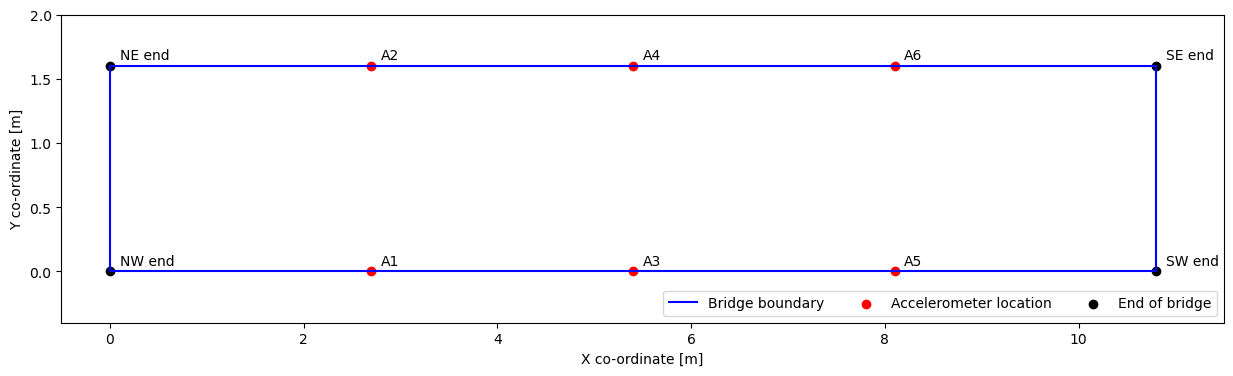

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
url = "https://edacab.readthedocs.io/en/latest/Welcome_page_and_tutorials/_static/LT2_co_ords.csv"

co_ords = pd.read_csv(url)
fg,ax = plt.subplots(figsize=(15,4))
ax.plot([0,10.8,10.8,0,0],[1.6,1.6,0,0,1.6],c='b',label='Bridge boundary')
ax.scatter(co_ords['X'].iloc[:-4],co_ords['Y'].iloc[:-4],c='r',label='Accelerometer location')
ax.scatter(co_ords['X'].iloc[-4:],co_ords['Y'].iloc[-4:],c='k',label='End of bridge')

ax.legend(loc=4,ncol=3)

for i in range(len(co_ords)):
    ax.annotate(co_ords['Loc'].iloc[i], (co_ords['X'].iloc[i]+0.1,co_ords['Y'].iloc[i]+0.05))
ax.set_ylim(-0.4,2)
ax.set_xlim(-0.5,11.5)
ax.set_xlabel('X co-ordinate [m]')
ax.set_ylabel('Y co-ordinate [m]');

## Data collection

Acceleration data is continuously collected at a sample rate of 1024Hz. The data transmitted from the bridge is raw voltage data and has not been filtered or downsampled after the analogue-to-digital conversion.

## Accessing the data
The livestream of acceleration data can be accessed via [websockets](https://en.wikipedia.org/wiki/WebSocket) using the [Flask API websocket package](https://flask-socketio.readthedocs.io/en/latest/). To connect to the bridge we send a request for data and establish a connection to the livestream.

### Connecting to the livestream data
The first step is to connect to the bridge via a websocket. This is achieved via the [LT2 Smarter Bridge dashboard](https://smarterbridge.herokuapp.com/). We'll start by loading the packages needed for establishing the connection and defining  a simple function to access the data. For the first example we'll wait until data is recieved before closing the connection.

In [1]:
# Importing the relevant libraries
import numpy as np
import time # Used for controlling when commands are executed
# The main function that will handle connection and communication
# with the server is socketio
import socketio

sio = socketio.Client()

@sio.on('all data from server')
def direct_all_from_server(message):
    global dat
    dat = message
    # Print the length of the data
    print('Data recieved, length = '+str(len(message)))


# Connect to the smart bridge server
sio.connect('https://smarterbridge.herokuapp.com/')
sio.emit('requestor connect') # Send a request to access the data coming from the bridge

dat='' # Blank variable used for storing the data
time_to_disconnect = 5 # If for whatever reason we don't recieve data after 5 seconds we'll disconnect
time_start = time.time() # Used for tracking when we started the connection

# Run code for five seconds, unless we recieve data from the bridge
while time.time()-time_start<time_to_disconnect:
    # Disconnect once we recieve data from the server
    if len(dat)>0:
        sio.disconnect()
        break
    time.sleep(0.01) # If we haven't recieved data from the server sleep for 0.01 seconds

Data recieved, length = 706613
Data recieved, length = 706613


Now that we've recieved data from the bridge, let's print part of the data to understand the encoding.

In [4]:
print(dat[:100])

1663838959.8478103[[-1.482e-03,-1.350e-03,-1.489e-03,-1.542e-03,-1.538e-03,-1.598e-03,
  -1.658e-03,


The data is transmitted in two parts. The first number before "\[" is the [UNIX time](https://en.wikipedia.org/wiki/Unix_time) at which the data was transmitted from the server. Everything within the square brackets is the raw voltage output from the accelerometers. The code below will decode this data string into a usable form.

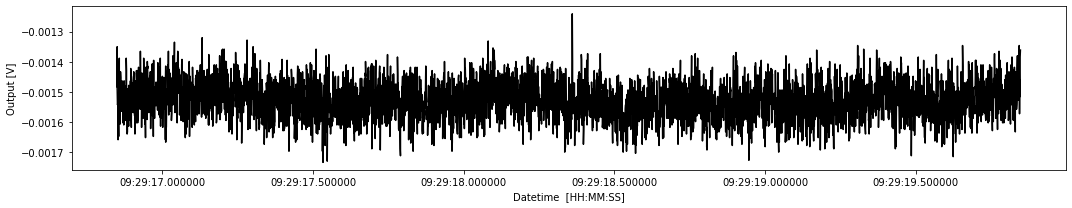

In [6]:
import numpy as np
import matplotlib.pyplot as plt # Used for plotting the data
import matplotlib.dates as mdates # Used for plotting datetimes

# Extract the time stamp
t_stamp = dat.split('[')[0]

# Extract the raw acceleration data (in volts)
x0 = np.array(eval(dat[len(t_stamp):]))

# Create a time array using the time stamp
t_stamp = float(t_stamp) # Convert the time stamp from a string to a float
fs = 1707.76 # Sample rate of the data
t = np.arange(t_stamp-(len(x0[0])/fs),t_stamp,1/fs)
# Convert the time from UNIX time to a NumPy datetime format
t = (t*1000).astype('datetime64[ms]') # Note we need to multiply by 1000 to convert from seconds to milliseconds

# Plot the time against acceleration data
fg,ax = plt.subplots(figsize=(15,3))
ax.plot(t,x0[0],c='k') # Plot output from an accelerometer
ax.set_ylabel('Output [V]')
ax.set_xlabel('Datetime  [HH:MM:SS]')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S.%f")) # Set the formatting of the datetime x-axis
fg.tight_layout()

The data is organized with odd numbered columns (1,3,5,7,9,11) corresponding to the vertical acceleration data from accelerometers A1Z to A6Z, and even numbered columns (2,4,6,8,10,12) corresponding to the transverse acceleration data from accelerometers A1Y to A6Y.

### Plotting real-time livestream data
We can enclose the conversion and plotting commands in a while loop to constantly update the plots as new data is recieved. The code below will run for 60 seconds and update the plot each time new data is recieved.

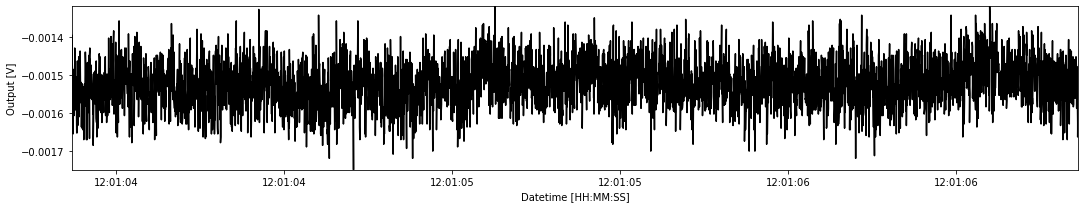

In [5]:
import time
# The main function that will handle connection and communication
# with the server
import socketio
import numpy as np
import matplotlib.pyplot as plt # Used for plotting the data
import matplotlib.dates as mdates # Used for plotting datetimes
from IPython.display import display, clear_output

sio = socketio.Client()

@sio.on('all data from server')
def direct_all_from_server(message):
    global t,x0
    dat = message
    # Extract the time stamp
    t_stamp = dat.split('[')[0]
    # Extract the raw acceleration data (in volts)
    x0 = np.array(eval(dat[len(t_stamp):]))
    # Create a time array using the time stamp
    t0 = np.arange(float(t_stamp)-(len(x0[0])/fs),float(t_stamp),1/fs)
    # Convert the time from UNIX time to a NumPy datetime format
    t = (t0*1000).astype('datetime64[ms]') # Note we need to multiply by 1000 to convert from seconds to milliseconds
    
sio.connect('https://smarterbridge.herokuapp.com/')
sio.emit('requestor connect')
running=True

x0 = np.zeros((1,1)) # A dummy array used for creating the plot before we've recieved data
t = np.zeros(1) # A dummy array used for creating the plot before we've recieved data

time_to_disconnect = 60
time_start = time.time()
fs = 1707.76 # Sample rate of the data

# Create an empty plot to be updated
fg,ax = plt.subplots(figsize=(15,3))
plotted_data, = ax.plot(t,x0[0],c='k')
ax.set_ylabel('Output [V]')
ax.set_xlabel('Datetime [HH:MM:SS]')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S")) # Set the formatting of the datetime x-axis

fg.tight_layout()
plt.pause(0.01)
while time.time()-time_start<time_to_disconnect:
    if len(t)>1:
        try:
            plotted_data.set_data(t,x0[0]) # Update the plotted data
            ax.set_xlim(np.min(t),np.max(t)) # Update the x-axis of the plot
            ax.set_ylim(np.min(x0[0]),np.max(x0[0])) # Update the y-axis of the plot
            display(fg) # Update the displayed plot
            clear_output(wait=True)
        except:
            time.sleep(0.1)

sio.disconnect()

### Exploring the livestream data

We can use the example code above as a template for creating other functions. For example, the code below calculates and plots the power spectral density of the data. 

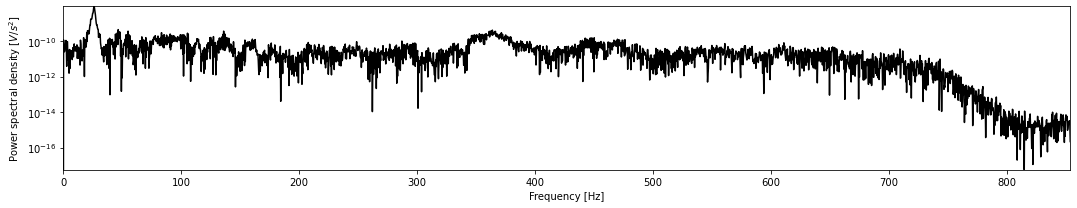

In [10]:
import time
# The main function that will handle connection and communication
# with the server
import socketio
import numpy as np
import matplotlib.pyplot as plt # Used for plotting the data
import matplotlib.dates as mdates # Used for plotting datetimes
from IPython.display import display, clear_output
from scipy.signal import periodogram

sio = socketio.Client()

@sio.on('all data from server')
def direct_all_from_server(message):
    global f,psd,fs
    dat = message
    # Extract the time stamp
    t_stamp = dat.split('[')[0]
    
    # Extract the raw acceleration data (in volts)
    x0 = np.array(eval(dat[len(t_stamp):]))
    # Calculate power spectral density of the data
    f,psd = periodogram(x0,fs)


sio.connect('https://smarterbridge.herokuapp.com/')
sio.emit('requestor connect')
running=True

psd = np.ones((1,1)) # A dummy array used for creating the plot before we've recieved data
f = np.zeros(1) # A dummy array used for creating the plot before we've recieved data

time_to_disconnect = 20
time_start = time.time()
fs = 1707.76 # Sample rate of the data

# Create an empty plot to be updated
fg,ax = plt.subplots(figsize=(15,3))
plotted_data, = ax.semilogy(f,psd[0],c='k')
ax.set_ylabel('Power spectral density [$V/s^2$]')
ax.set_xlabel('Frequency [Hz]')
fg.tight_layout()

while time.time()-time_start<time_to_disconnect:
    if len(f)>1:
        try:
            plotted_data.set_data(f,psd[0]) # Update the plotted data
            ax.set_xlim(np.min(f),np.max(f)) # Update the x-axis of the plot
            ax.set_ylim(np.min(psd[0,1:]),np.max(psd[0,1:])) # Update the y-axis of the plot
            display(fg) # Update the displayed plot
            clear_output(wait=True)
        except:
            time.sleep(0.1)

sio.disconnect()

### Caching data
The bridge server only caches and transfers a maximum of 5 seconds of data. Alongside this, the reciever code does not track whether the current data being transmitted from the bridge has already been received, or what the overlap between data previously received and newly received data is. To collect larger sections of data the code below can be used. This code compares newly received data to previously received data and discards any that has previously been collected.

**Note**: This code is designed for collecting relatively short periods of data. For longer data sets it is advisable to save the data at frequent intervals and compile all data to a single file at a later date.

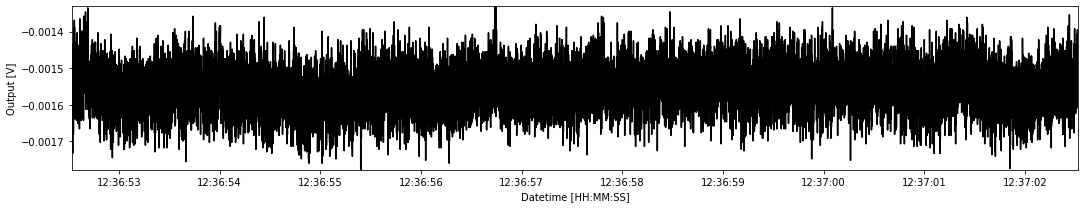

In [14]:
import time
# The main function that will handle connection and communication
# with the server
import socketio
import numpy as np
import matplotlib.pyplot as plt # Used for plotting the data
import matplotlib.dates as mdates # Used for plotting datetimes
from IPython.display import display, clear_output

sio = socketio.Client()

@sio.on('all data from server')
def direct_all_from_server(message):
    global x0_all,t,fs
    dat = message
    # Extract the time stamp
    t_stamp = dat.split('[')[0]

    x0 = np.array(eval(dat[len(t_stamp):]))

    if len(x0_all)==0:
        x0_all=x0
    else:
        tmp = x0[0,:]
        search_term = x0_all[0,-5:]
        occ = [i for i, a in enumerate(tmp) if a == search_term[0]]
        index=-1
        if len(occ)>0:
            for b in occ:
                if np.all(tmp[b:b+len(search_term)] == search_term):
                    index = b
                    break
            if index==-1:
                x0_all = np.hstack((x0_all,x0))
            else:
                x0_all = np.hstack((x0_all,x0[:,index:]))

        else:
            x0_all = np.hstack((x0_all,x0))
        x0_all = x0_all[:,:max_length]
        # Create a time array using the time stamp
        t_stamp = float(t_stamp) # Convert the time stamp from a string to a float

        t0 = np.arange(t_stamp-(len(x0_all[0])/fs),t_stamp,1/fs)
        # Convert the time from UNIX time to a NumPy datetime format
        t = (t0*1000).astype('datetime64[ms]') # Note we need to multiply by 1000 to convert from seconds to milliseconds


sio.connect('https://smarterbridge.herokuapp.com/')
sio.emit('requestor connect')
running=True

x0_all = []
t = []

time_to_disconnect = 60
time_start = time.time()
fs = 1707.76 # Sample rate of the data
max_length = int(10*fs) # Maximum length of data to cache


# Create an empty plot to be updated
fg,ax = plt.subplots(figsize=(15,3))
plotted_data, = ax.plot(0,0,c='k')
ax.set_ylabel('Output [V]')
ax.set_xlabel('Datetime [HH:MM:SS]')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S")) # Set the formatting of the datetime x-axis
fg.tight_layout()

while time.time()-time_start<time_to_disconnect:
    if len(t)>1:
        try:
            if len(t)==len(x0_all[0]): # This line prevents us trying to plot the acceleration data before the time data has been updated
                plotted_data.set_data(t,x0_all[0]) # Update the plotted data
                ax.set_xlim(np.min(t),np.max(t)) # Update the x-axis of the plot
                ax.set_ylim(np.min(x0_all[0,:]),np.max(x0_all[0,:])) # Update the y-axis of the plot
                display(fg) # Update the displayed plot
                clear_output(wait=True)
        except:
            time.sleep(0.1)

sio.disconnect()